# Tópico 17 - Trabalho final da disciplina (Aplicação de DSP Áudio ou Imagem)

Aplicação de Processamento Digital de Sinais (DSP) em Sonar do Tipo *Echosounder* para Detecção de Profundidade do Fundo e Realização de Batimetria

## Alunos

* Alejo Perdomo Milar
* João Mário C. I. Lago

## Contexto

Este trabalho aborda a aplicação de Processamento Digital de Sinais (DSP) em um sonar do tipo *Echosounder* para a detecção da profundidade do fundo de rios, lagos ou mares com finalidade batimétrica. Discute-se o tratamento do sinal recebido e os métodos utilizados para estimar a profundidade. O trabalho apresenta a fundamentação teórica, a implementação em código Python e a posterior otimização para um microcontrolador STM32F303RETx (Cortex-M4), utilizando intrínsecas e técnicas SIMD para execução paralela.

No contexto moderno, existem diversas tecnicas de compressão de pulso que sonares podem utilizar para aumentar a sua resolução de range, porém o trabalho a seguir irá apresentar a implementação mais simples e comunmente usada em sonares de baixo custo que consiste em um pulso de frequencia unica e a detecção de tempo de voo do echo de forma simples utilizando apenas filtros simples (passa faixa e passa baixa) sem técnincas mais avançadas de compressão de pulso ou filtros casados.

## Fundamentação

### Sequência de transmissão e eco

<div style="display: flex; justify-content: center;">
    <img src="./assets/application-overview.drawio.png" height="420" alt="Visão geral da transmissão e recepção do pulso sonar">
</div>

### Perfil temporal do sinal

<div style="display: flex; justify-content: center;">
    <img src="./assets/typical-profile.drawio.png" height="420" alt="Perfil temporal típico do sinal transmitido e do eco">
</div>

### Arquitetura de referência


<div style="display: flex; justify-content: center;">
    <img src="./assets/sonar-overview.drawio.png" height="420" alt="Arquitetura completa do echosounder">
</div>

### Objetivo do documento



## Implementação Python

Primeiramente será realizado uma implementação dos processos mencionados acima em python para se facilitar a compreensão dos processos que deseja-se atingir e posteriormente será realizado o port para um código C em especifico otimizando para utilização de intrínsecas e técnicas SIMD para um cortex M4.

### Blibliotecas e imports

In [2]:
%pip install -q numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Sinal original

Nesta seção é carregado um sinal de exemplo contendo a transmissão do pulso sonar e o eco recebido.
O eco provém da reflexão do pulso com o fundo, que está localizado a 0,69 m de distância.

O sinal apresenta as seguintes características:

A primeira parte de alta energia corresponde à transmissão do pulso sonar.
Em seguida, há um período de fundo de ruído até a recepção do eco. Após esse período, observa-se um pico de energia de menor amplitude que corresponde ao eco do pulso refletido.

O sinal está centralizado em torno do valor 127, que representa o valor médio da escala do ADC de 8 bits.


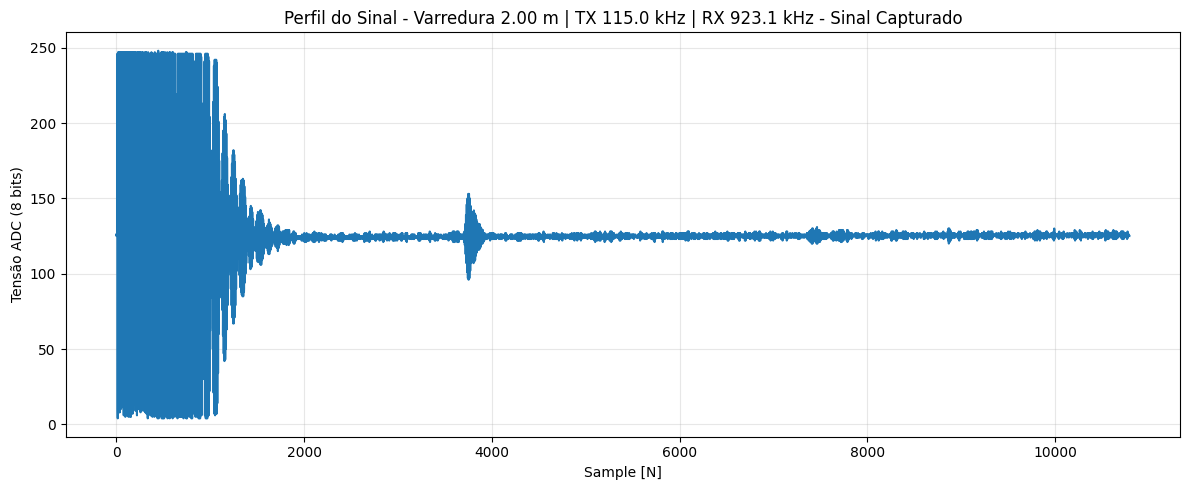

In [4]:
from assets.sample import (
    data as raw_adc_data,
    scan_length_mm,
    tx_freq,
    rx_sampling_freq,
    speed_of_sound,
)

# Converte os valores carregados para float e evita alterar a lista original fornecida pelos assets
signal_samples = [float(sample) for sample in raw_adc_data]

# Texto padrão utilizado em todos os gráficos desta análise
BASE_PLOT_TITLE = (
    f"Perfil do Sinal - Varredura {scan_length_mm / 1000:.2f} m | "
    f"TX {tx_freq / 1000:.1f} kHz | RX {rx_sampling_freq / 1000:.1f} kHz"
)


def plot_signal(
    samples,
    *,
    overlay=None,
    overlay_labels=None,
    vertical_marker=None,
    horizontal_marker=None,
    title_suffix="",
    main_label=None,
):
    """Gera gráficos padronizados para o sinal e camadas auxiliares."""
    plt.figure(figsize=(12, 5))

    if main_label:
        plt.plot(samples, label=main_label)
    else:
        plt.plot(samples)

    if overlay:
        labels = overlay_labels or [None] * len(overlay)
        for extra_series, extra_label in zip(overlay, labels):
            plt.plot(extra_series, label=extra_label)

    if vertical_marker is not None:
        plt.axvline(
            x=vertical_marker,
            color="r",
            linestyle="--",
            label="Marcador Vertical",
        )

    if horizontal_marker is not None:
        plt.axhline(
            y=horizontal_marker,
            color="r",
            linestyle="--",
            label="Marcador Horizontal",
        )

    plt.title(f"{BASE_PLOT_TITLE}{title_suffix}")
    plt.xlabel("Sample [N]")
    plt.ylabel("Tensão ADC (8 bits)")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    legend_needed = any(
        [
            main_label,
            overlay and any(overlay_labels or []),
            vertical_marker is not None,
            horizontal_marker is not None,
        ]
    )
    if legend_needed:
        plt.legend()

    plt.show()

# Visualiza o sinal bruto antes de qualquer transformação
plot_signal(signal_samples, title_suffix=" - Sinal Capturado")


### Retificação

Para facilitar a detecção do eco por threshold, é necessário remover a componente contínua do sinal. Isso centraliza o sinal em torno de zero. Em seguida, o sinal é retificado, fazendo com que todos os valores fiquem positivos, o que simplifica a aplicação de limiares para detecção.

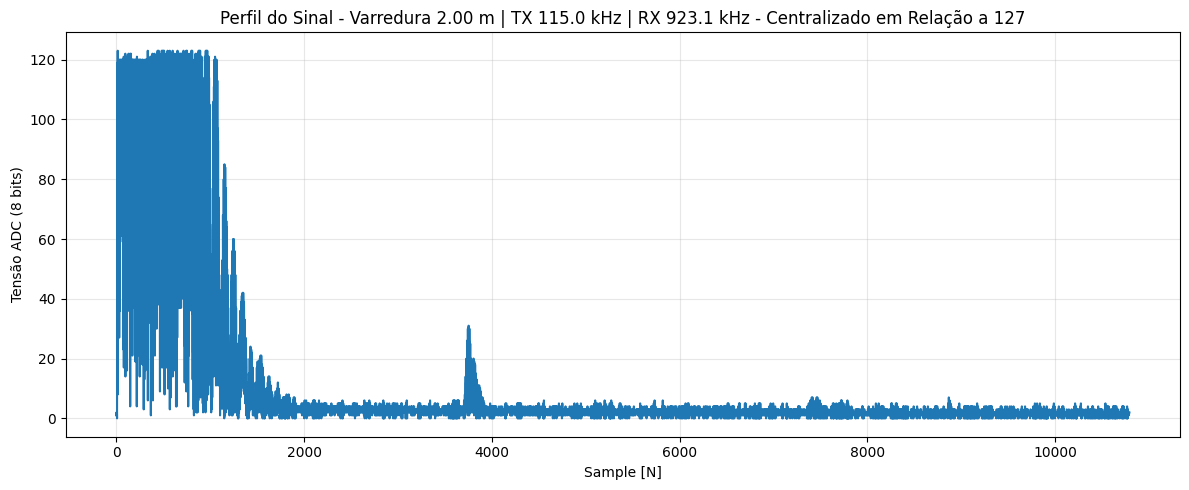

In [5]:
# Centraliza o sinal em torno de 127 para remover o offset do ADC
for index, value in enumerate(signal_samples):
    if value >= 127:
        signal_samples[index] = value - 127
    else:
        signal_samples[index] = 127 - value

plot_signal(
    signal_samples,
    title_suffix=" - Centralizado em Relação a 127",
)


### Amplificação

Para aumentar a sensibilidade na detecção, uma vez que após a retificação o sinal encontra-se na faixa de 0 a 127, é aplicado um ganho exponencial que amplifica preferencialmente os pulsos de energia, que são as áreas de interesse, enquanto o fundo de ruído recebe menor amplificação.

#### Por que amplificação não-linear?

A amplificação não-linear (quadrática) é preferível à amplificação linear porque:

1. **Amplificação seletiva**: Valores altos (pulsos de interesse) são amplificados mais que valores baixos (ruído)

2. **Melhora da relação sinal-ruído**: O eco, que possui amplitude maior, recebe ganho proporcionalmente maior que o ruído de fundo

3. **Preservação da dinâmica**: Mantém a diferença relativa entre sinais fortes e fracos, facilitando a detecção por threshold

#### Fórmula de amplificação

A fórmula utilizada é:

```
valor_amplificado = valor × (valor / 2)
```

Isso é equivalente a `valor² / 2`, ou seja, metade do quadrado do valor. O fator de divisão por 2 evita que valores moderados (por exemplo, 50) sejam amplificados excessivamente antes da saturação.

#### Saturação

O sinal é então limitado ao valor máximo de 255 para manter a escala de 8 bits do ADC. Valores que excederem 255 após a amplificação são saturados (clamped) em 255, preservando a faixa dinâmica do sistema de aquisição.

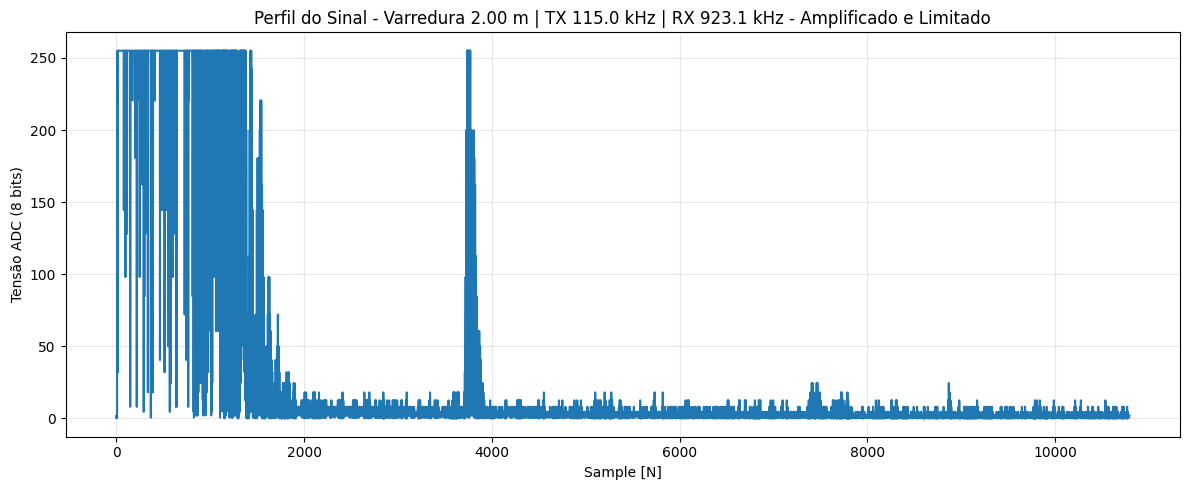

In [6]:
# Amplifica o conteúdo útil e aplica saturação para manter o sinal em 8 bits
for index, value in enumerate(signal_samples):
    amplified_value = value * (value / 2.0)
    signal_samples[index] = min(amplified_value, 255)

plot_signal(
    signal_samples,
    title_suffix=" - Amplificado e Limitado",
)


### Cancelamento do piso de ruído

Nesta etapa, é calculado o desvio padrão da metade final do sinal, utilizando essa região para evitar a influência da sombra de transmissão do pulso inicial.
Em seguida, todos os valores do sinal que estiverem abaixo do desvio padrão calculado são zerados, removendo efetivamente o piso de ruído de fundo.

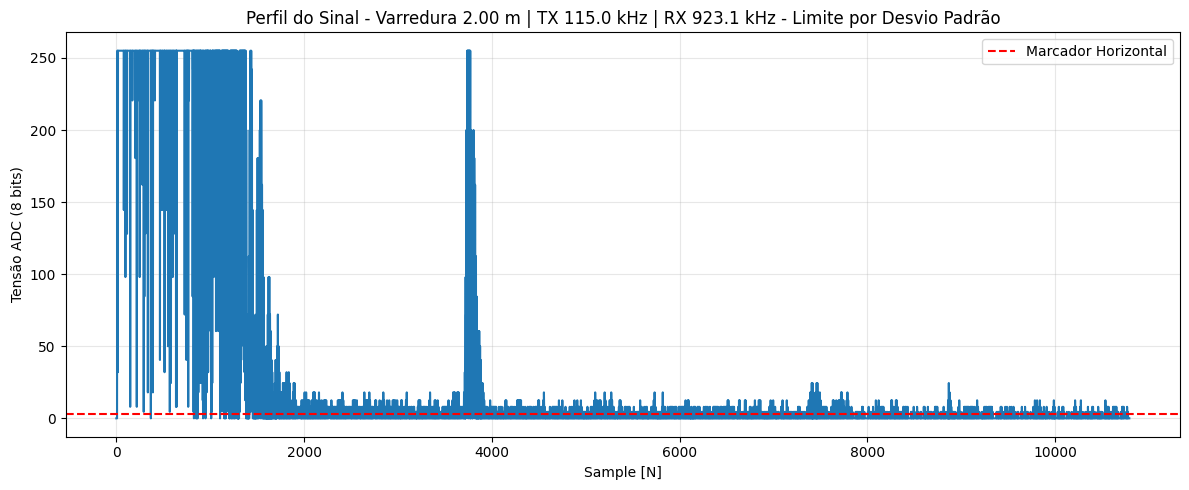

In [7]:
# Calcula o desvio padrão da metade final para identificar o piso de ruído
signal_tail = signal_samples[len(signal_samples) // 2 :]
tail_std_dev = np.std(signal_tail)

# Mantém apenas valores acima do desvio padrão calculado
for index, value in enumerate(signal_samples):
    signal_samples[index] = value if value > tail_std_dev else 0

plot_signal(
    signal_samples,
    horizontal_marker=tail_std_dev,
    title_suffix=" - Limite por Desvio Padrão",
)


### Remoção da sombra de transmissão

#### O problema da sombra de transmissão

Após a transmissão do pulso sonar, o transdutor piezoelétrico continua vibrando por um período devido à sua **ressonância mecânica**. Essa vibração residual gera um sinal de alta energia que "cega" o receptor, impedindo a detecção de ecos próximos. Esse fenômeno é conhecido como **sombra de transmissão** (transmission shadow)

#### Estratégia de detecção

Para remover a sombra de transmissão, é criada uma janela deslizante e calculada a energia média dessa janela. A janela é então deslizada ao longo do sinal até encontrar a primeira região onde a energia média cai abaixo do desvio padrão previamente calculado, indicando o fim do período de transmissão e o início da região útil para detecção do eco.

Intervalo entre amostras: 1.08 us


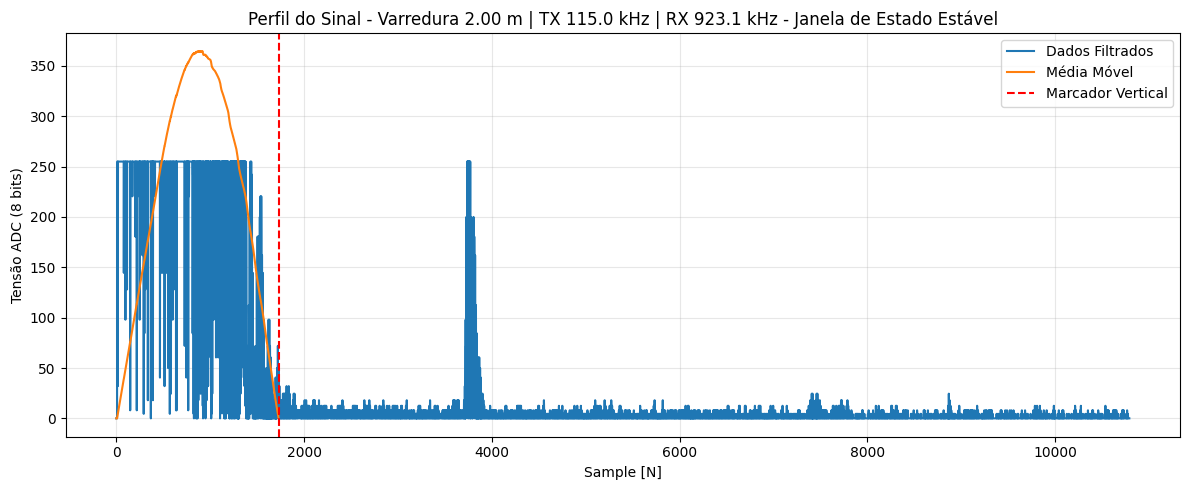

In [8]:
# Define a janela desejada (500 us) e calcula o intervalo entre amostras
sample_interval_us = (1.0 / float(rx_sampling_freq)) * 1e6
print(f"Intervalo entre amostras: {sample_interval_us:.2f} us")
steady_state_window_samples = int(500.0 / sample_interval_us)

# Usa o desvio padrão (com mínimo 5) como limiar para detectar o fim do transiente
steady_state_threshold = tail_std_dev if tail_std_dev > 5 else 5

moving_average_values = []
window_accumulator = 0.0
steady_state_end_index = 0

# Inicializa a soma da primeira janela
for i in range(steady_state_window_samples):
    window_accumulator += signal_samples[i]
    moving_average_values.append(window_accumulator / steady_state_window_samples)

# Desliza a janela e para quando a energia cai abaixo do limiar
for i in range(
    steady_state_window_samples,
    len(signal_samples) - steady_state_window_samples,
):
    window_accumulator -= moving_average_values[i - steady_state_window_samples]
    window_accumulator += signal_samples[i]

    if window_accumulator < steady_state_threshold:
        steady_state_end_index = i
        break

    moving_average_values.append(window_accumulator / steady_state_window_samples)

plot_signal(
    signal_samples,
    overlay=[moving_average_values],
    overlay_labels=["Média Móvel"],
    vertical_marker=steady_state_end_index,
    title_suffix=" - Janela de Estado Estável",
    main_label="Dados Filtrados",
)


## Detecção de eco

### Algoritmo de detecção

Nesta etapa, é criada uma janela deslizante e calculada a energia média dessa janela. A janela é então deslizada ao longo do sinal (ignorando o trecho da sombra de transmissão) até encontrar a primeira região onde a energia média ultrapassa um limiar predefinido, indicando a presença do eco refletido do fundo.


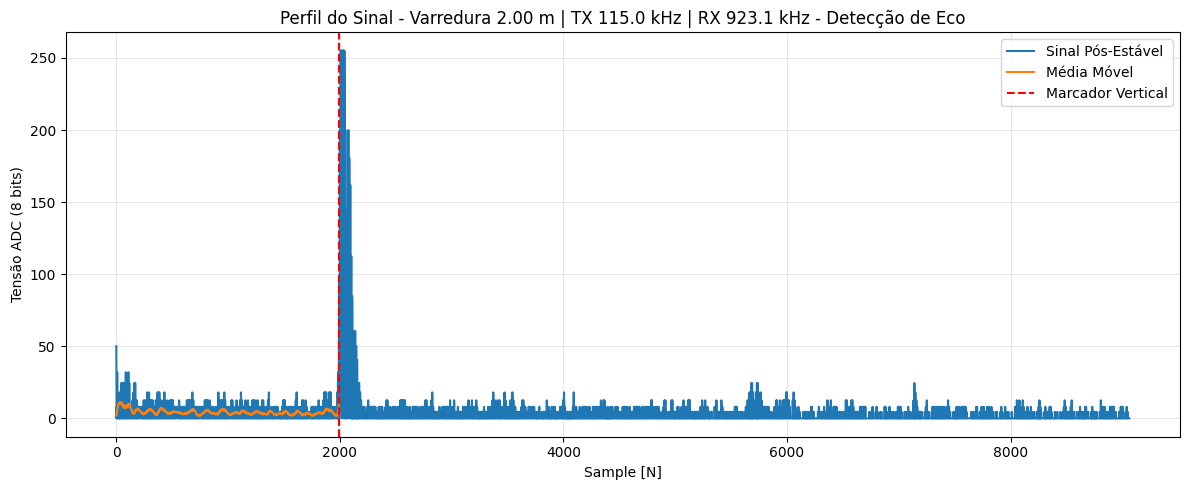

In [9]:
# Descarta o trecho anterior ao fim do estado transitório
signal_samples = signal_samples[steady_state_end_index:]

# Configura a janela de 350 us para encontrar ecos significativos
echo_window_size = 24

echo_threshold = 15 * echo_window_size

echo_window_values = []
echo_window_accumulator = 0.0
echo_index = 0

# Inicializa a média móvel da nova janela
for i in range(echo_window_size):
    echo_window_accumulator += signal_samples[i]
    echo_window_values.append(echo_window_accumulator / echo_window_size)

# Desliza a janela e registra o primeiro pico acima do limiar
for i in range(echo_window_size, len(signal_samples) - echo_window_size):
    echo_window_accumulator -= echo_window_values[i - echo_window_size]
    echo_window_accumulator += signal_samples[i]

    if echo_window_accumulator > echo_threshold:
        echo_index = i
        break

    echo_window_values.append(echo_window_accumulator / echo_window_size)

plot_signal(
    signal_samples,
    overlay=[echo_window_values],
    overlay_labels=["Média Móvel"],
    vertical_marker=echo_index,
    title_suffix=" - Detecção de Eco",
    main_label="Sinal Pós-Estável",
)
echo_index += steady_state_end_index

### Cálculo da profundidade e confiança do sinal

#### Cálculo da Profundidade

Quando o transdutor emite um pulso, ele viaja até o fundo, reflete e retorna ao receptor. A distância total percorrida pelo som é o dobro da profundidade (ida e volta).

A profundidade é calculada através da seguinte relação:

```
profundidade = (tempo_total / 2) × velocidade_do_som
```

Onde:
- `tempo_total` é o tempo decorrido desde a transmissão até a recepção do eco
- A divisão por 2 é necessária porque o som percorre a distância duas vezes (ida e volta)

Em termos de amostras digitais:

```
mm_por_amostra = (1 / frequência_amostragem) × velocidade_do_som / 2
profundidade = índice_do_eco × mm_por_amostra
```

O fator de conversão `mm_per_sample_point` representa quantos milímetros cada amostra digital corresponde no mundo físico, considerando a frequência de amostragem do ADC e a velocidade do som no meio.

#### Cálculo da Confiança

A confiança da medição é uma métrica que indica a qualidade do sinal recebido. Ela é calculada baseando-se no desvio padrão do ruído de fundo:

```
confiança = (1 - desvio_padrão / 255) × 100%
```

Onde:
- `desvio_padrão` é o desvio padrão calculado na metade final do sinal (região de ruído)
- `255` é o valor máximo da escala do ADC de 8 bits

**Interpretação:**
- **Confiança alta (>95%)**: Sinal limpo, ruído baixo, medição confiável
- **Confiança média (70-95%)**: Sinal aceitável, mas com algum ruído
- **Confiança baixa (<70%)**: Sinal ruidoso, medição pode ser imprecisa

Uma confiança alta indica que o eco foi detectado com clareza sobre um fundo de ruído baixo, enquanto uma confiança baixa sugere que o sinal pode estar contaminado por interferências ou que o eco é muito fraco.

In [10]:
mm_per_sample_point = ((1.0 / rx_sampling_freq) * speed_of_sound) / 2.0

depth_mm = mm_per_sample_point * echo_index
confidence = (1.0 - (tail_std_dev / 255.0)) * 100.0

print(f"Profundidade estimada: {depth_mm / 1e3:.2f} m")
print(f"Confiança: {confidence:.2f}%")

Profundidade estimada: 0.69 m
Confiança: 98.90%


## Algorítimo C

### Retificação

A função **u8_fast_abs_delta** tem como objetivo transformar cada amostra `buffer[i]` em `abs(buffer[i] - center)`, removendo a componente contínua e retificando o sinal.

A função processa o buffer **em blocos de 8 amostras por iteração**:

* Cada `uint32_t` contém 4 amostras.
* O loop processa **2 grupos de 4 amostras** por vez, totalizando 8 amostras por iteração do `while`.
* Essa abordagem reduz o overhead do loop e aproveita as intrínsecas SIMD do processador.

###### Para cada grupo de 4 amostras é executado o seguinte:

**1. Comparação SIMD usando `__USUB8`**

```cpp
__USUB8(*iter_buff, center_pack);
```

Esta intrínseca executa uma **subtração byte a byte** (`*iter_buff - center_pack`), mas o resultado numérico é ignorado. O interesse está nas **flags GE** (Greater or Equal) que são definidas pelo processador para cada byte:

| Condição | Flag GE | Significado |
|----------|---------|-------------|
| `sample ≥ center` | GE = 1 | Sample é maior ou igual ao centro |
| `sample < center` | GE = 0 | Sample é menor que o centro |
Com uma única instrução, o processador realiza **4 comparações simultâneas** em paralelo, eliminando a necessidade de branches condicionais (`if`).

---

**2. Seleção condicional usando `__SEL`**

```cpp
frac1 = __SEL(*iter_buff, center_pack);
```

A intrínseca `__SEL(a, b)` realiza uma **seleção condicional byte a byte** entre `a` e `b`, utilizando as flags GE definidas anteriormente:

| Flag GE | Seleção | Resultado |
|---------|---------|-----------|
| GE = 1 | Seleciona byte de `a` | `frac1` recebe o byte de `*iter_buff` |
| GE = 0 | Seleciona byte de `b` | `frac1` recebe o byte de `center_pack` |

**Resultado:** `frac1` contém, em cada byte, **o maior valor entre `sample` e `center`**.

---

**3. Seleção invertida para obter o menor valor**

```cpp
frac2 = __SEL(center_pack, *iter_buff);
```

A mesma lógica é aplicada, mas com a ordem dos argumentos invertida:

| Flag GE | Seleção | Resultado |
|---------|---------|-----------|
| GE = 1 | Seleciona byte de `a` (`center_pack`) | `frac2` recebe `center` |
| GE = 0 | Seleciona byte de `b` (`*iter_buff`) | `frac2` recebe `sample` |

**Resultado:** `frac2` contém, em cada byte, **o menor valor entre `sample` e `center`**.

**Resumo após as duas seleções:**

| Variável | Conteúdo (por byte) |
|----------|---------------------|
| `frac1` | `max(sample, center)` |
| `frac2` | `min(sample, center)` |

---

**4. Subtração para calcular diferença positiva**

```cpp
frac1 = __USUB8(frac1, center_pack);
```

Subtrai `center` de `frac1` **byte a byte**. Como `frac1` contém sempre valores ≥ `center`, o resultado é:

| Condição | Cálculo | Resultado em `frac1` |
|----------|---------|---------------------|
| `sample ≥ center` | `max(sample, center) - center` | `sample - center` |
| `sample < center` | `center - center` | `0` |

---

**5. Subtração invertida para calcular diferença negativa**

```cpp
frac2 = __USUB8(center_pack, frac2);
```

Subtrai `frac2` de `center` **byte a byte**. Como `frac2` contém sempre valores ≤ `center`, o resultado é:

| Condição | Cálculo | Resultado em `frac2` |
|----------|---------|---------------------|
| `sample ≤ center` | `center - min(sample, center)` | `center - sample` |
| `sample > center` | `center - center` | `0` |

**Resultado final das subtrações:**

Em cada byte, **exatamente um** dos dois registradores contém a diferença absoluta, enquanto o outro contém zero:

| Byte | `frac1` | `frac2` | Resultado |
|------|---------|---------|-----------|
| `sample ≥ center` | `sample - center` | `0` | Diferença positiva |
| `sample < center` | `0` | `center - sample` | Diferença negativa (absoluta) |

---

**6. Combinação final com OR bit a bit**

```cpp
*iter_buff = frac1 | frac2;
```

Realiza uma operação **OR bit a bit** entre `frac1` e `frac2` (byte a byte). Como para cada byte exatamente um dos dois registradores contém zero e o outro contém a diferença:

**Resultado:** Cada byte do buffer contém `abs(sample - center)`, que é o valor absoluto da diferença entre a amostra e o centro.

As 4 amostras foram transformadas em seus valores absolutos de delta e gravadas de volta no buffer.


```cpp
/**
 * @brief Computes the absolute delta of each element in a buffer from a center value.
 *
 * Optimized for buffer sizes that are integer multiples of 8. For example, if a center
 * value of 127U is provided, the absolute delta is computed as:
 *
 * @code
 * value = value > 127U ? value - 127U : 127U - value;
 * @endcode
 *
 * @param[in,out] buffer Pointer to the buffer to process. The result is stored in the same buffer.
 * @param[in] size Number of elements in the buffer to process.
 * @param[in] center_pack The center value to compute the absolute delta.
 */
void u8_fast_abs_delta(volatile uint8_t *buffer, uint16_t size, uint32_t center_pack)
{
  /** Temporary memory for operations */
  uint32_t frac1;
  uint32_t frac2;
  /** We take 4 by 4 samples per time of the buffer */
  uint32_t *iter_buff = (uint32_t*)buffer;

  uint16_t block = size >> 3U;
  while (block > 0) {
    /** This one is trick, but it uses the GE flag on the CPU to simulate 4 ifs at once and the operation */

    /**
     * Lest suppose *iter_buffer = 80 174 80 174
     *
     * When we use USUB8 it will set GE to 1 flag for each byte of the operation if the result is greater or equal to 0
     *
     * 80 - 127 -> GE = 0
     * 174 - 127 -> GE = 1
     * 80 - 127 -> GE = 0
     * 174 - 127 -> GE = 1
     */
    __USUB8(*iter_buff, center_pack);

    /**
     * Now we have the GE flags set for each byte of the operation, SEL will select bytes from *iter_buff and center_pack
     * based on the GE flags, if GE is 1 it will select the byte from *iter_buff, if GE is 0 it will select the byte
     * from center_pack
     *
     * GE is 0 -> Select 127
     * GE is 1 -> Select 174
     * GE is 0 -> Select 127
     * GE is 1 -> Select 174
     *
     * frac1 = 127 174 127 174
     */
    frac1 = __SEL(*iter_buff, center_pack);

    /**
     * GE is 0 -> Select 80
     * GE is 1 -> Select 127
     * GE is 0 -> Select 80
     * GE is 1 -> Select 127
     *
     * frac2 = 80 127 80 127
     */
    frac2 = __SEL(center_pack, *iter_buff);

    /**
     * Now we have the two fractions, we need to subtract 127 from the first one and the second one from 127
     *
     * 127 - 127 = 0
     * 174 - 127 = 47
     * 127 - 127 = 0
     * 174 - 127 = 47
     *
     * frac1 = 0 47 0 47
     */
    frac1 = __USUB8(frac1, center_pack);

    /**
     * 127 - 80 = 47
     * 127 - 127 = 0
     * 127 - 80 = 47
     * 127 - 127 = 0
     *
     * frac2 = 47 0 47 0
     */
    frac2 = __USUB8(center_pack, frac2);

    /**
     * Now we have the two fractions, we need to OR them to get the final result
     *
     * 0 | 47 = 47
     * 47 | 0 = 47
     * 0 | 47 = 47
     * 47 | 0 = 47
     *
     * *iter_buff = 47 47 47 47
     */
    *iter_buff = frac1 | frac2;

    /** Next 4 samples */
    ++iter_buff;

    /** And so on... */

    __USUB8(*iter_buff, center_pack);
    frac1 = __SEL(*iter_buff, center_pack);
    frac2 = __SEL(center_pack, *iter_buff);
    frac1 = __USUB8(frac1, center_pack);
    frac2 = __USUB8(center_pack, frac2);
    *iter_buff = frac1 | frac2;
    ++iter_buff;

    /** Next block */
    --block;
  }
```


### Amplificação

Quando a flag `isProfileEnhanced` é verdadeira, o sinal é amplificado utilizando uma função que eleva cada amostra ao quadrado e divide o resultado por dois, amplificando preferencialmente os pulsos de maior energia.

O objetivo da função **u8_fast_half_square** é transformar cada amostra `buffer[i]` em:

```
(buffer[i] * buffer[i]) / 2
```

Essa operação é computacionalmente equivalente a:

```
value * (value >> 1)
```

A função processa o buffer **em blocos de 8 amostras por iteração**:

* Cada iteração do `while` processa **8 valores**, agrupados 2 a 2.
* Para cada par de amostras, são calculados **dois “meios quadrados”** (half-square) dentro de um único registrador de 32 bits:

  * Cada resultado ocupa um `uint16_t`.
* O ARM executa saturação com **__USAT16**, que limita o resultado a **8 bits** por canal.
* Cada par de amostras é processado sem branches, usando loop unrolling para reduzir overhead do loop.

###### A cada par de amostras (2 samples) é executado o seguinte:

---

```cpp
iter_reg[0] = buffer[0] * (buffer[0] >> 1);
```

* `buffer[0] >> 1` divide o sample por 2.
* Multiplica o valor original pelo valor dividido por 2 → **meio do quadrado**.
* O resultado é armazenado nos **16 bits baixos** de `reg`.

---

```cpp
iter_reg[1] = buffer[1] * (buffer[1] >> 1);
```

* Mesmo cálculo para a segunda amostra.
* O resultado é armazenado nos **16 bits altos** de `reg`.

Após essas duas operações:

* `reg` contém:

```
[ meia quadrado sample1 ][ meia quadrado sample0 ]
```

cada um com 16 bits.

---

**3. Saturação SIMD usando `__USAT16`**

```cpp
sat = __USAT16(reg, 8U);
```

A intrínseca `__USAT16` realiza **saturação independente** em cada metade de 16 bits do registrador:

| Operação | Descrição |
|----------|-----------|
| Metade inferior (16 bits baixos) | Satura para **8 bits** (faixa 0–255) |
| Metade superior (16 bits altos) | Satura para **8 bits** (faixa 0–255) |

**Estrutura do resultado (`sat`):**

| Byte | Posição | Conteúdo |
|------|---------|----------|
| Byte 0 | 16 bits baixos, parte baixa | Resultado saturado do **sample 0** |
| Byte 1 | 16 bits baixos, parte alta | Sempre **zero** |
| Byte 2 | 16 bits altos, parte baixa | Resultado saturado do **sample 1** |
| Byte 3 | 16 bits altos, parte alta | Sempre **zero** |

**Representação visual:**

```
sat = [ 0 | sample1_sat | 0 | sample0_sat ]
       └─┬─┘ └─────┬─────┘ └─┬─┘ └─────┬─────┘
         │         │         │         │
      Byte 3    Byte 2    Byte 1    Byte 0
```

---

```cpp
buffer[0] = iter_sat[0];
```

* `iter_sat` é um ponteiro para os bytes de `sat`.
* `iter_sat[0]` contém o byte menos significativo:

  * Resultado saturado do **sample 0**.
* Esse byte substitui o valor original no buffer.

---

```cpp
buffer[1] = iter_sat[2];
```

* `iter_sat[2]` contém o resultado saturado do **sample 1**.
* Grava o valor processado no buffer.

Após isso:

* Os dois samples foram transformados em seus **half-square clampados para 8 bits**.
* O buffer foi avançado para o próximo par.

---

A mesma sequência é repetida para samples:

* 2 e 3
* 4 e 5
* 6 e 7

Cada grupo de 2 samples segue exatamente o mesmo padrão:

1. Calcula o half-square para cada um.
2. Coloca os 2 resultados em `reg`.
3. Executa saturação com `__USAT16`.
4. Extrai cada byte saturado.
5. Sobrescreve no buffer.
6. Avança o ponteiro.


### Normalização

#### u8_fast_max

O objetivo de **u8_fast_max** é encontrar o **maior valor de todo o buffer** de `uint8_t`.

A função processa o buffer **em blocos de 8 amostras por iteração**:

* Cada `uint32_t` contém **4 amostras**.
* O loop processa **2 grupos de 4 amostras**, totalizando **8 samples por iteração**.
* O algoritmo usa intrínsecas SIMD (`__USUB8`, `__SEL`) para comparar **4 bytes em paralelo**, sem `if`.

Durante o loop, o registrador `max` mantém **4 máximos parciais**, um por byte.

---

##### Para cada grupo de 4 samples é executado o seguinte:

**1. Comparação SIMD para identificar valores maiores**

```cpp
__USUB8(*iter_buff, max);
```

Executa subtração byte a byte (`sample[i] - max[i]`), mas **o resultado numérico não é utilizado**. O interesse está nas **flags GE** definidas para cada byte:

| Condição | Flag GE | Significado |
|----------|---------|-------------|
| `sample ≥ max` | GE = 1 | Sample é maior ou igual ao máximo atual |
| `sample < max` | GE = 0 | Sample é menor que o máximo atual |

Com uma única instrução, o processador realiza **4 comparações simultâneas**, eliminando branches condicionais.

**2. Atualização do máximo usando seleção condicional**

```cpp
max = __SEL(*iter_buff, max);
```

A intrínseca `__SEL(a, b)` seleciona **byte a byte** baseado nas flags GE:

| Flag GE | Seleção | Resultado |
|---------|---------|-----------|
| GE = 1 | Seleciona byte de `a` (`*iter_buff`) | Mantém ou atualiza com o sample |
| GE = 0 | Seleciona byte de `b` (`max`) | Mantém o máximo atual |

**Resultado:** Em cada byte de `max`, fica armazenado o **maior valor** entre o máximo parcial atual e o sample correspondente.

Após essa operação, o registrador `max` contém **4 máximos parciais atualizados**.

---

```cpp
++iter_buff;
```

* Avança para o próximo grupo de 4 samples.

---

Essa mesma lógica é repetida para as próximas 4 amostras:

```cpp
__USUB8(*iter_buff, max);
max = __SEL(*iter_buff, max);
++iter_buff;
```

---

```cpp
--block;
```

* Avança para o próximo bloco de 8 samples.

---

##### Após processar todos os blocos

O registrador `max` contém **4 valores**, cada um representando o máximo encontrado em um dos 4 “fluxos paralelos” processados pelos bytes do registrador.

Agora é necessário extrair os 4 bytes e encontrar o maior entre eles.

---

##### Seleção final do máximo global

Primeiro emparelhamento:

```cpp
uint8_t f1 = (max >> 24U) > ((max << 8U) >> 24U)
             ? (max >> 24U)
             : ((max << 8U) >> 24U);
```

* Compara o byte 3 com o byte 2.
* Seleciona o maior: resultado vai para `f1`.

---

Segundo emparelhamento:

```cpp
uint8_t f2 = ((max << 16U) >> 24U) > ((max << 24U) >> 24U)
             ? ((max << 16U) >> 24U)
             : ((max << 24U) >> 24U);
```

* Compara o byte 1 com o byte 0.
* Seleciona o maior: resultado vai para `f2`.

---

##### Resultado final

```cpp
return f1 > f2 ? f1 : f2;
```

* Compara os dois maiores intermediários.
* O maior deles é o **máximo global do buffer**.


Após encontrar o máximo global, o buffer é normalizado utilizando esse valor máximo como referência.

#### u8_fast_normalize

O objetivo da função **u8_fast_normalize** é transformar cada amostra `buffer[i]` em:

```
value = saturate( value * 256 / max )
```

Ou seja:
**normalizar todos os valores do buffer para a faixa 0–255**

A função processa o buffer **em blocos de 8 amostras por iteração**, mas:

* Diferente das funções anteriores, esta só consegue processar **2 samples por vez**.

Cada par de samples é processado usando um registrador de 32 bits dividido em duas metades de 16 bits.

---

##### Fator de normalização

```cpp
uint16_t factor = (1 << 16) / max;
```

* Computa um fator de escala de 16 bits para obter boa precisão.
* O cálculo final usa:
  `(value * factor) >> 8`, equivalente a `value * 256 / max`.

Isso permite normalizar valores usando apenas multiplicações inteiras e shifts.

---

##### Para cada par de 2 samples, é executado o seguinte:

---

```cpp
iter_reg[0] = (buffer[0] * factor) >> 8;
```

* Calcula a normalização do primeiro sample:

* Multiplica o sample por `factor`.
* Faz um shift à direita de 8 bits (divide por 256).
* O resultado é um **valor normalizado em 16 bits**, antes da saturação.
* Esse resultado é gravado nos **16 bits baixos** do registrador `reg`.

---

```cpp
iter_reg[1] = (buffer[1] * factor) >> 8;
```

* Mesmo processo para o segundo sample.
* Gravado nos **16 bits altos** de `reg`.

Após essas duas operações:

```
reg = [ normalized_sample1_16bit | normalized_sample0_16bit ]
```

---

```cpp
sat = __USAT16(reg, 8U);
```

* Aplica **saturação independente** a cada metade de 16 bits.
* Cada metade é saturada para **8 bits** (0–255).
* O resultado (`sat`) possui:

* Byte 0 → sample normalizado 0
* Byte 2 → sample normalizado 1
* Bytes 1 e 3 sempre zero

Representação:

```
sat = [ 0 | sample1_sat | 0 | sample0_sat ]
```

---

```cpp
buffer[0] = iter_sat[0];
```

* Escreve o valor saturado do **primeiro sample** de volta no buffer.

---

```cpp
buffer[1] = iter_sat[2];
```

* Escreve o valor saturado do **segundo sample**.

---

```cpp
++buffer;
++buffer;
```

* Avança o ponteiro para o próximo par de samples.

---

As mesmas operações são repetidas para:

* Samples 2 e 3
* Samples 4 e 5
* Samples 6 e 7

Sempre com:

1. Cálculo de normalização
2. Escrita em `reg`
3. Saturação com `__USAT16`
4. Extração dos bytes válidos
5. Escrita no buffer
6. Avanço do ponteiro

---

```cpp
--block;
```




### Estatísticas

#### u8_fast_mean

O objetivo da função **u8_fast_mean** é calcular a **média aritmética** de um buffer de valores `uint8_t` de forma otimizada, processando 8 amostras por iteração.

A função usa intrínsecas SIMD de 64 bits para reduzir carregamentos individuais e somar vários bytes ao mesmo tempo.

---

##### Processamento em blocos de 8 samples

A função processa o buffer agrupando 8 valores `uint8_t` em um único registrador `uint64_t`:

**1. Carregamento SIMD de 8 bytes**

```cpp
in = *_SIMD64(buffer)++;
```

| Operação | Descrição |
|----------|-----------|
| `_SIMD64(buffer)` | Reinterpreta o ponteiro como `uint64_t*` |
| `*_SIMD64(buffer)` | Lê **8 bytes consecutivos** como um único registrador de 64 bits |
| `++` | Avança o ponteiro em **8 bytes** automaticamente |

**Vantagem:** Reduz drasticamente o overhead de leituras individuais, carregando 8 valores em uma única operação.

---

##### Acumulação SIMD dos 8 valores

**2. Soma paralela dos 8 bytes**

```cpp
_ACC_ADD_SIMD64(acc, in)
```

Esta macro realiza a soma de cada um dos 8 bytes contidos em `in` ao acumulador `acc` de forma otimizada:

```
acc += b0 + b1 + b2 + b3 + b4 + b5 + b6 + b7;
```

---

##### Avança para o próximo bloco

```cpp
--block;
```

Cada iteração processa exatamente 8 elementos.

---

##### Média final

```cpp
return acc / size;
```

* Ao final do loop, `acc` contém a soma completa de todas as amostras.
* Dividir pela quantidade total de elementos retorna a **média aritmética**.

---

##### Resumo (alto nível) – `u8_fast_mean`

1. Carrega 8 bytes por vez usando `_SIMD64`.
2. Soma os 8 bytes usando `_ACC_ADD_SIMD64`.
3. Repete até processar todo o buffer.
4. Divide a soma total pelo tamanho → **média**.

---

#### u8_fast_std_dev

O objetivo de **u8_fast_std_dev** é calcular o **desvio padrão** rápido de um buffer de `uint8_t`, assumindo que a **média já foi calculada** e passada como argumento.

A função calcula o desvio padrão utilizando a fórmula:

```
std_dev = sqrt( mean(square) – square(mean) )
```

O buffer é processado em blocos de 8 amostras usando um registrador de 64 bits.

---

##### Pré-cálculo: quadrado da média

```cpp
uint16_t square_of_mean = mean * mean;
```

* Necessário para aplicar a fórmula do desvio padrão.
* É usado somente no final.

---

##### Processamento SIMD de 8 samples por iteração

**1. Carregamento SIMD de 8 bytes**

```cpp
in = *_SIMD64(buffer)++;
```

* Lê 8 bytes consecutivos como um único `uint64_t`.
* Avança o ponteiro em 8 bytes.

---

**2. Soma dos quadrados dos 8 bytes**

```cpp
_ACC_ADD_SQ_SIMD64(sum_of_squares, in)
```

* Expande cada byte contido em `in`.
* Calcula o quadrado de cada um.
* Soma os 8 quadrados ao acumulador `sum_of_squares`.

**Equivalência:** Substitui eficientemente a operação sequencial:

```cpp
sum_of_squares += b0*b0 + b1*b1 + b2*b2 + b3*b3 + b4*b4 + b5*b5 + b6*b6 + b7*b7;
```

**Vantagem:** Utiliza instruções SIMD otimizadas do ARM, processando os 8 valores em paralelo sem loops internos.

---

##### Cálculo do tamanho efetivo processado

```cpp
mean_of_squares = sum_of_squares / ((size >> 3U) << 3U);
```

* Como a função processa **somente múltiplos de 8**, esta expressão:

  * Remove os últimos valores se `size` não for múltiplo de 8.
  * Exemplo: 26 elementos → processa só 24.




### Cancelamento do ruído de fundo

#### u8_fast_threshold_cut

O objetivo da função **u8_fast_threshold_cut** é aplicar um corte por limiar (threshold) no buffer, substituindo valores **abaixo do limiar por zero** e mantendo inalterados os valores **acima ou iguais ao limiar**.

A lógica equivalente em código C seria:

```c
value = value < threshold ? 0 : value;
```

A função processa o buffer em **blocos de 8 amostras por iteração**, trabalhando 4 amostras por vez através de um `uint32_t`, usando instruções SIMD do ARM para comparar 4 bytes de forma paralela.

---

##### Processamento de cada grupo de 4 samples

###### 1. Comparação SIMD usando `__USUB8`

```cpp
__USUB8(*iter_buff, threshold_pack);
```

Executa subtração byte a byte (`sample[i] - threshold`), mas **o resultado numérico não é utilizado**. Apenas as **flags GE** (Greater or Equal) são importantes:

| Condição | Flag GE | Significado |
|----------|---------|-------------|
| `sample ≥ threshold` | GE = 1 | Sample mantém seu valor |
| `sample < threshold` | GE = 0 | Sample deve ser zerado |

**Vantagem:** Uma única instrução realiza **4 comparações simultâneas**, eliminando branches condicionais.

---

###### 2. Seleção condicional dos valores com `__SEL`

```cpp
*iter_buff = __SEL(*iter_buff, 0U);
```

A intrínseca `__SEL(a, b)` seleciona **byte a byte** baseado nas flags GE:

| Flag GE | Seleção | Resultado |
|---------|---------|-----------|
| GE = 1 | Seleciona byte de `a` (`*iter_buff`) | Mantém o valor original |
| GE = 0 | Seleciona byte de `b` (`0U`) | Substitui por zero |

**Resultado final:**

| Operação | Efeito |
|----------|--------|
| Valores `≥ threshold` | Permanecem inalterados |
| Valores `< threshold` | São substituídos por **zero** |

**Exemplo prático:**

| Posição | Sample Original | Threshold | Flag GE | Resultado |
|---------|----------------|-----------|---------|-----------|
| Byte 0 | 5 | 10 | 0 | **0** |
| Byte 1 | 50 | 10 | 1 | **50** |
| Byte 2 | 8 | 10 | 0 | **0** |
| Byte 3 | 20 | 10 | 1 | **20** |

---

###### 3. Avanço para os próximos 4 samples

```cpp
++iter_buff;
```

* Avança o ponteiro reinterpretado de `uint32_t*` para o próximo grupo de 4 bytes.

---

###### 4. Repetição do processo para o segundo grupo de 4 samples

```cpp
__USUB8(*iter_buff, threshold_pack);
*iter_buff = __SEL(*iter_buff, 0U);
++iter_buff;
```

Cada iteração do `while` processa exatamente **8** amostras (2 blocos de 4).

---

###### 5. Controle do loop

```cpp
--block;
```

* Cada bloco corresponde a 8 amostras processadas.
* O loop continua até que todos os blocos sejam consumidos.




### Remoção da sombra de transmissão

#### steady_state_finder

O objetivo da função **steady_state_finder** é identificar **onde a ressonância do transdutor piezoelétrico termina** dentro de um buffer de amostras, ou seja, o ponto em que o sinal entra em um estado estável (steady state) após o término da transmissão do pulso.

A estratégia utilizada é:

1. Criar uma **janela deslizante** (moving window) de tamanho `window_size`.
2. Calcular a soma de todos os valores dentro da janela.
3. Deslocar a janela ao longo do buffer:

   * Adicionando os novos valores que entram na janela.
   * Subtraindo os valores que saem da janela.
4. A janela é considerada em **steady state** quando:

   ```
   soma_da_janela < window_size * std_deviation
   ```

Ou seja, quando a soma total dentro da janela fica suficientemente baixa em relação ao desvio padrão, indicando que a ressonância do transdutor terminou e o sinal estabilizou.

---

##### Etapas da Função

###### 1. Variáveis principais

```cpp
uint64_t in;               // registrador temporário para carregar 8 samples
uint32_t w_acc = 0U;       // acumulador da soma da janela
volatile uint8_t *tail = buffer;  // aponta para o início da janela
uint32_t target = window_size * std_deviation;  // limite de steady state
```

* `w_acc` guarda a soma atual da janela deslizante.
* `tail` acompanha os elementos que estão saindo da janela conforme ela se move.
* `target` é o nível máximo permitido para considerar a janela estável.

---

###### 2. Inicialização da janela

Primeiro, calcula-se a soma de `window_size` elementos.

A função processa **8 samples de cada vez**, usando `_SIMD64`.

```cpp
uint16_t block = window_size >> 3U;
```

A janela é dividida em blocos de 8 elementos.

###### Para cada bloco:

**Carregamento e acumulação SIMD:**

```cpp
in = *_SIMD64(buffer)++;   // lê 8 u8 como um u64 e avança o buffer
_ACC_ADD_SIMD64(w_acc, in) // soma os 8 valores ao acumulador
```

| Operação | Descrição |
|----------|-----------|
| `*_SIMD64(buffer)++` | Carrega **8 bytes consecutivos** como um `uint64_t` e avança o ponteiro |
| `_ACC_ADD_SIMD64(w_acc, in)` | Soma os **8 bytes** de `in` ao acumulador `w_acc` de forma otimizada |

**Vantagem:** Substitui 8 somas individuais por uma única operação SIMD otimizada.

Quando todos os blocos são processados, `w_acc` contém:

```
soma dos primeiros window_size elementos
```

---

###### 3. Verificação imediata do steady state

```cpp
if (w_acc < target) {
    return 0U;
}
```

Se logo no início o sinal já estiver abaixo do threshold:

* Steady state começa no início do buffer.
* Retorna `0`.

---

###### 4. Deslizamento da janela ao longo do buffer

Agora a janela começa a ser deslocada pelo restante do buffer.

```cpp
block = (size - window_size) >> 3U;
```

Isso determina quantos deslocamentos completos (de 8 samples) podem ser feitos.

###### Para cada deslocamento de 8 posições:

1. **Entram 8 novos samples**:

```cpp
in = *_SIMD64(buffer)++;
_ACC_ADD_SIMD64(w_acc, in)
```

2. **Saem 8 samples antigos**:

```cpp
in = *_SIMD64(tail)++;
_ACC_DEC_SIMD64(w_acc, in)
```

`_ACC_DEC_SIMD64` subtrai os 8 bytes representados por `in` do acumulador.

3. **Checagem do steady state**:

```cpp
if (w_acc < target) {
    return size - (block << 3U);
}
```

O ponto identificado é:

```
pos = posição no buffer onde a janela ficou abaixo do threshold
```

O cálculo usa:

* `block << 3U` → quantidade de elementos que ainda faltam ser processados
* `size - (block << 3U)` → index do início da janela atual

Assim, o retorno indica **o índice onde a ressonância terminou e o sinal estabilizou**.

---

###### 5. Caso nenhum steady-state tenha sido encontrado

```cpp
return 0U;
```

Se o loop terminar sem que a soma caia abaixo do threshold, a função retorna 0 como fallback.


### Detecção do eco

#### echo_finder

O objetivo da função **echo_finder** é detectar **onde o eco refletido começa** dentro de um buffer de amostras.

A função utiliza uma janela deslizante (moving window) para identificar **a primeira região onde a soma dos valores da janela excede um limiar baseado no desvio padrão**, indicando a presença do eco refletido do fundo.

##### Estrutura Geral do Algoritmo

1. Calcula a soma inicial de uma janela de tamanho `window_size`.
2. Compara essa soma com o threshold:

   ```
   target = threshold * window_size
   ```
3. Se a soma ultrapassar o limite na janela inicial → eco começa logo no início.
4. Caso contrário, desliza a janela ao longo do buffer:

   * Adiciona novos 8 samples
   * Remove os 8 samples antigos
   * Verifica novamente se a soma ultrapassa o threshold
5. Quando isso acontece, retorna o índice onde o eco é detectado.
6. Se a análise chega ao final sem cruzar o threshold, retorna 0.

---

##### Explicação Detalhada

###### Variáveis principais

```cpp
uint64_t in;               // registrador para leitura SIMD de 8 samples
uint32_t w_acc = 0U;       // acumulador da soma da janela
volatile uint8_t *tail = buffer;  // aponta para os elementos que deixam a janela
uint32_t target = threshold * window_size;
```

* `w_acc` mantém a soma atual da janela.
* `tail` acompanha os elementos que estão saindo da janela deslizante.
* `target` define o limite acima do qual o eco é considerado detectado.

---

###### Inicialização da janela

A primeira janela de `window_size` elementos deve ser somada.
Assim como em funções anteriores, o processamento é feito **em blocos de 8**:

```cpp
uint16_t block = window_size >> 3U;
```

###### Para cada bloco inicial:

```cpp
in = *_SIMD64(buffer)++;   // lê 8 bytes como um u64
_ACC_ADD_SIMD64(w_acc, in) // soma os 8 bytes ao acumulador
```

Quando o loop termina, `w_acc` contém:

```
soma dos primeiros window_size elementos
```

---

###### Verificação inicial do threshold

```cpp
if (w_acc > target) {
    return 1U;
}
```

Se a soma da janela inicial já exceder o limite:

* O eco está presente logo no início.
* Retorna índice 1.

---

###### Deslizamento da janela ao longo do buffer

Após a janela inicial, o algoritmo move a janela para frente:

```cpp
block = (size - window_size) >> 3U;
```

Isso determina quantas posições de 8 em 8 podem ser percorridas.

###### Para cada deslocamento:

1. **Entrada de novos 8 samples na janela**

```cpp
in = *_SIMD64(buffer)++;
_ACC_ADD_SIMD64(w_acc, in)
```

2. **Saída de antigos 8 samples da janela**

```cpp
in = *_SIMD64(tail)++;
_ACC_DEC_SIMD64(w_acc, in)
```

3. **Verificação do threshold**

```cpp
if (w_acc > target) {
    return size - (block << 3U);
}
```

Esse cálculo determina o índice correspondente ao ponto onde a janela passou do threshold.

Ele funciona porque:

* `block << 3U` representa quantos elementos ainda faltam ser analisados à frente.
* `size - (block << 3U)` é o índice atual da janela na varredura.

---

###### Caso nenhum eco seja detectado

```cpp
return 0U;
```

Se a varredura completa não encontrar uma soma acima do threshold, a função retorna 0.

## Código completo

### Visão geral do fluxo de processamento

A função `processProfile()` orquestra todas as etapas do processamento do sinal sonar em sequência. O fluxo completo segue a mesma lógica da implementação Python, mas com otimizações SIMD:

#### Etapas do processamento (em ordem):

1. **Preparação da janela de steady state**: Calcula o tamanho da janela deslizante baseado no intervalo de amostragem (aproximadamente 350 µs)

2. **Retificação** (`u8_fast_abs_delta`): Remove a componente DC e retifica o sinal, centralizando-o em torno de zero

3. **Amplificação** (`u8_fast_half_square`, condicional): Se `_isProfileEnhanced` estiver ativo, amplifica preferencialmente os pulsos de alta energia

4. **Normalização** (`u8_fast_max` + `u8_fast_normalize`, condicional): Se `_isProfileNormalized` estiver ativo e o sinal não usar toda a escala, normaliza para aproveitar melhor a faixa dinâmica

5. **Cálculo de estatísticas** (`u8_fast_mean` + `u8_fast_std_dev`): Calcula média e desvio padrão da metade final do sinal (região de ruído puro)

6. **Cancelamento de ruído** (`u8_fast_threshold_cut`, condicional): Se amplificação estiver ativa, remove valores abaixo do desvio padrão

7. **Detecção do fim da transmissão** (`steady_state_finder`): Identifica onde a ressonância do transdutor termina usando janela deslizante

8. **Detecção do eco** (`echo_finder`): Busca o primeiro pico de energia acima do threshold na região após o steady state

9. **Cálculo final**: Converte o índice do eco em profundidade (mm) e calcula a confiança da medição

10. **Validação**: Verifica se o sinal é confiável (desvio padrão < 200, média < 150) e ajusta a confiança


```cpp
void PingSonar::processProfile()
{
  /** Start cleaning buffer and preparing for search algorithms */

  /** We aim for around 350 us for the steady state window */
  uint16_t steady_state_window_size = (uint16_t)(350.0f / _sampleInterval);
  steady_state_window_size = (steady_state_window_size >> 3U) << 3U;

  /** Center based absolute difference to convert offset AC to pulsed DC */
  u8_fast_abs_delta(_DMABufferADC4, _sampleCycles, __U32_127);

  /** Amplify differences using half square */
  if (_isProfileEnhanced) {
    u8_fast_half_square(_DMABufferADC4, _sampleCycles);
  }

  /** Usually will never be needed bu if the data does not uses the whole range scale it */
  if (_isProfileNormalized) {
    uint8_t max = u8_fast_max(_DMABufferADC4, _sampleCycles);

    if (max < 255U) {
      u8_fast_normalize(_DMABufferADC4, _sampleCycles, max);
    }
  }

  /** Extract statistical data and verifies if it is usable */
  uint16_t half_buffer_size = _sampleCycles >> 1U;
  uint8_t mean = u8_fast_mean(&_DMABufferADC4[half_buffer_size], half_buffer_size);
  uint8_t std_dev = u8_fast_std_dev(&_DMABufferADC4[half_buffer_size], half_buffer_size, mean);

  /** Clean the thrash and make it easy for the searches */
  if (_isProfileEnhanced) {
    u8_fast_threshold_cut(_DMABufferADC4, _sampleCycles, _U32_PACK(std_dev));
  }

  /** Finds where the Piezo relaxed and stopped blinding us */
  uint8_t steady_finder_threshold = (std_dev > 10U) ? std_dev : 10U;
  uint16_t steady_state_index = steady_state_finder(
    _DMABufferADC4, _sampleCycles, steady_state_window_size, steady_finder_threshold
  );
  /** We only need to search for peak after this point */
  uint16_t remainder_search_size = _sampleCycles - steady_state_index;

  /** Finds where peak is */
  uint16_t peak_index = echo_finder(
    &_DMABufferADC4[steady_state_index], remainder_search_size, ECHO_FINDER_WINDOW_SIZE, ECHO_FINDER_THRESHOLD
  );
  uint16_t final_peak_index = (peak_index + steady_state_index) >> 1U;

  if (peak_index != 0U) {
    _lockedDistance = (uint32_t)((float)(final_peak_index * _mmPerSamplePoint) + _realRangeScanStart);
    _lockedConfidence = (1.0f - ((float)std_dev / 255.0f)) * 100.0f;

    /** If standard deviation is grater than 80% or mean value is to high */
    if (std_dev > 200U || mean > 150U) {
      _lockedConfidence = 0U;
    }

    if (_lockedConfidence > 95U) {
      _lockedConfidence = 100U;
    }
  } else {
    /** No lock... */
    _lockedDistance = 0U;
    _lockedConfidence = 0U;
  }
}
```

## Conclusão

Este trabalho apresentou a implementação de um sistema de processamento digital de sinais para detecção de profundidade utilizando um sonar do tipo echosounder. A solução foi desenvolvida em duas etapas: primeiro uma implementação em Python para facilitar a compreensão dos algoritmos, e posteriormente uma versão otimizada em C utilizando intrínsecas SIMD do ARM Cortex-M4.

O algoritmo implementado processa o sinal recebido através de etapas sequenciais: retificação, amplificação, normalização, cálculo de estatísticas, cancelamento de ruído de fundo, remoção da sombra de transmissão e detecção do eco. A otimização para o microcontrolador STM32F303RETx demonstra como técnicas SIMD podem ser empregadas para processar múltiplas amostras em paralelo, aumentando significativamente a eficiência computacional.

Os resultados obtidos validam a abordagem proposta, permitindo a detecção precisa da profundidade do fundo com uma confiança adequada para aplicações batimétricas em sistemas embarcados de baixo custo.
